<a href="https://colab.research.google.com/github/jadytian/ML-predict-kinase-inhibitor/blob/main/predict_kinase_inhibitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Whether a Drug is a Kinase Inhibitor Using Small-Molecule Structure Information
Jady Tian

# Part 1: Preparing and Generating Descriptor Data

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

--2020-12-13 07:31:46--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-12-13 07:31:46--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   155MB/s    in 0.5s    

2020-12-13 07:31:47 (155 MB/s) - ‘Minicon

In [3]:
!time conda install -q -y -c conda-forge rdkit

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py37he5a615d_2         335 KB  conda-forge
    boost-cpp-1.74.0           |       h9359b55_0        16.4 MB  conda-forge
    bzip2-1.0.8                |       h516909a_3         398 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    cairo-1.16.0               |    h3fc0475_1005         1.5 MB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_0         143 KB  conda-forge
    conda-4.9.2                |   py37h89c1867_0         3.0 MB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    fontconfig-2.13.1          |    h7e3eb15_1002         324 KB  conda-forge
    freetype-2.10.

In [4]:
!time conda install -q -y -c conda-forge py3dmol

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - py3dmol


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    argon2-cffi-20.1.0         |   py37h4abf009_2          47 KB  conda-forge
    async_generator-1.10       |             py_0          18 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    backcall-0.2.0             |     pyh9f0ad1d_0          13 KB  conda-forge
    backports-1.0              |             py_2           4 KB  conda-forge
    backports.functools_lru_cache-1.6.1|             py_0           8 KB  conda-forge
    bleach-3.2.1     

In [5]:
!time conda install -q -y -c mordred-descriptor mordred

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.8  |       h06a4308_0         121 KB
    certifi-2020.12.5          |   py37h06a4308_0         141 KB
    mordred-1.2.0              |     pyhe5148d4_0         257 KB  mordred-descriptor
    networkx-2.5               |             py_0         1.1 MB
    ------------------------------------------------------------
                                           Total:         1.6 MB

The following NEW packages will be INSTALLED:

  mordred            mordred-descriptor/noarch::mordred-1.2.0-pyhe5148d4_0
  networkx           pkgs/main/noarch::networkx-2.5-py_0

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certific

In [6]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [7]:
!pwd

/content


In [8]:
%cd gdrive/My Drive

/content/gdrive/My Drive


In [9]:
!mkdir -p Projects

In [10]:
%cd Projects

/content/gdrive/My Drive/Projects


In [11]:
# Run this the first time

In [12]:
#!git clone https://github.com/jadytian/ML-predict-kinase-inhibitor.git

In [13]:
%cd ML-predict-kinase-inhibitor

/content/gdrive/My Drive/Projects/ML-predict-kinase-inhibitor


We will be using a python package called mordred for generating **computer molecular descriptors**.

In [14]:
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors

#Create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)
df = pd.read_csv('combined.csv')

#Resample the imbalanced dataset(more details on this in Part2)
from sklearn.utils import resample
df_majority = df[df.Inhibitor=='No']
df_minority = df[df.Inhibitor=='Yes']

#Downsample majority class
df_majority_downsampled = resample(df_majority, replace = False, n_samples = 203, random_state=123)

#Combine the minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df = df_downsampled
x = df['SMILES'].values

#Calculate molecules
mols = [Chem.MolFromSmiles(smi) for smi in x]
df_m = calc.pandas(mols)


  2%|▏         | 10/406 [00:05<04:46,  1.38it/s]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  5%|▌         | 22/406 [00:15<11:27,  1.79s/it]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 406/406 [04:33<00:00,  1.48it/s]


In [15]:
# df_m = df_m.fillna(0) 

In [21]:
#Diasplay the descriptor table and convert to Numpy array
import numpy as np
print(df_m)
df_ms = np.asarray(df_m)


           ABC      ABCGG  nAcid  nBase  ... Zagreb1 Zagreb2 mZagreb1   mZagreb2
0    31.697605  23.233843      0      0  ...   194.0   202.0  18.7917  10.250000
1    18.372846  14.479004      0      0  ...   122.0   142.0  7.27778   5.500000
2    42.135164  31.576535      2      0  ...   294.0   353.0  20.5972  11.083333
3    13.980375  10.324630      0      2  ...    98.0   120.0  3.41667   3.611111
4    10.744501  10.170579      0      0  ...    66.0    72.0  5.58333   3.638889
..         ...        ...    ...    ...  ...     ...     ...      ...        ...
401   9.289847   8.749080      0      0  ...    62.0    73.0  3.94444   2.666667
402  26.208040  19.318438      0      1  ...   178.0   212.0  8.97222   7.194444
403  23.148902  19.019093      0      1  ...   162.0   200.0  7.97222   6.361111
404  10.094413   9.759293      0      0  ...    70.0    86.0  5.41667   2.833333
405  28.749097  21.532616      0      1  ...   190.0   216.0  13.9236   8.625000

[406 rows x 1613 columns]


# Part 2: Machine Learning for Predicting Whether a Drug is a Kinase Inhibitor Using Molecular Structures

## Preliminary Information 

Dataset Preparation:
*  Input dataset is constructed using Pubchem (https://pubchem.ncbi.nlm.nih.gov/)
*  Classifications on whether a drug is a kinase inhibitor or not is done through first collecting all cids of kinase inhibitors and sorting them out from the all drugs list of cids
*  The final dataset is consisted of three columns: cid, SMILE strings and whether or not the drug is a kinase inhibitor (labelled with Yes or No)

Machine Learning:
*  **Random Forest (RF)** Machine-Learning (ML) method was used for classification. 


### Here is a schematic overview of the modeling procedure

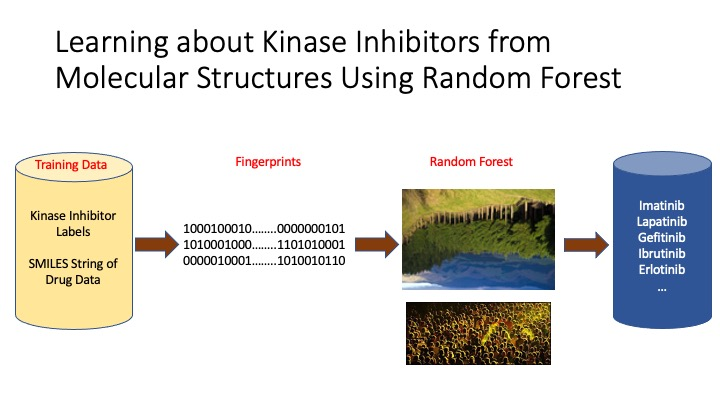

In [22]:
from IPython.display import Image
Image('KinaseInhibitorsModelling-banner.jpg')

### To create drug function classifier models, we need two things:

* Chemical structures and their associated class labels
* Descriptors (Fingerprints)

In [23]:
## Preliminary library setup
import os, random, time, numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit import RDLogger  
from rdkit.Chem import Draw
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

## Load the data 


In [24]:
import pandas as pd
df  = pd.read_csv('combined.csv')

print("Here are few first/last 5 lines of the df data")
df.iloc[0:6, [1,2]]

Here are few first/last 5 lines of the df data


,SMILES,Inhibitor
0,CC(C)C[C@@H](C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)...,No
1,CCOC1=CC=C(C=C1)N=NC2=CC(=C(C=C2)/C=C/C3=C(C=C...,No
2,CN(C1=CC(=CC=C1)OCF)C(=NC2=C(C=CC(=C2)SC)Cl)N,No
3,CCN1C2=C(C=C(C=C2)S(=O)(=O)O)C(C1=CC=CC3=[N+](...,No
4,CC(C)C[C@@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C...,No
5,CCCC(C(=O)CC)C(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)...,No


### Explore the dataset

In [25]:
print('Dimension of the dataset:', df.shape)

Dimension of the dataset: (130480, 3)


## Prepare the data for modeling
Because this is a highly **imbalanced** dataset with a significant higher number of non-kinase inhibitors versus very few samples of kinase inhibitors, we will be utilizing method of **upsampling** minority class or **down-sampling** majority class.

More information on this link:
https://elitedatascience.com/imbalanced-classes

The method I decide to go along with for this project is downsampling the majority class.

In [26]:
#We first explore the count of each class
df['Inhibitor'].value_counts()

No     130277
Yes       203
Name: Inhibitor, dtype: int64

In [28]:
#Import module for resampling
from sklearn.utils import resample

In [29]:
#Separate majority and minority classes
df_majority = df[df.Inhibitor=='No']
df_minority = df[df.Inhibitor=='Yes']

#Downsample majority class
df_majority_downsampled = resample(df_majority, replace = False, n_samples = 203, random_state=123)

#Combine the minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [32]:
#Updated class counts
df_downsampled.Inhibitor.value_counts()

Yes    203
No     203
Name: Inhibitor, dtype: int64

In [33]:
#Assign the updated dataset for analysis
df = df_downsampled

In [38]:
#Convert the dataframe to numpy ndarray
x = df['SMILES'].values
mols = [Chem.MolFromSmiles(smi) for smi in x]

In [39]:
#Encode inhibitor labels with value 0 and 1
outcome = df['Inhibitor'].values

le = preprocessing.LabelEncoder()
le.fit(outcome);

print('What labels are available in classes?:', list(le.classes_))
ys_fit = le.transform(outcome)

print('transformed outcome:  ', ys_fit)


What labels are available in classes?: ['No', 'Yes']
transformed outcome:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


The target labels are encoded as follows:
```
0: Not a Kinase Inhibitor (No)
1: Kinase Inhibitor (Yes)
```

## Data Analysis 
After resampling the dataset, this imbalanced dataset is balanced now, as illustrated below:

In [40]:
bin_count = np.bincount(ys_fit)
n_classes = len(bin_count)
print('How many classes? ',n_classes)
print('How many samples? ', len(ys_fit))

print('How many from each class (raw numbers)? ', bin_count )
print('How many from each class (proportions)?: ', bin_count/(sum(bin_count)))

How many classes?  2
How many samples?  406
How many from each class (raw numbers)?  [203 203]
How many from each class (proportions)?:  [0.5 0.5]


## Generate fingeprints: 

Read the following paper for details, https://www.ncbi.nlm.nih.gov/pubmed/20426451

In [41]:
#Generate the Fingerprints
#Time to generate the Fingerprints: 0.9676074981689453 seconds 

time_start = time.time()

from rdkit.Chem import AllChem

fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols if m != None]

#Convert RDKit explicit vectors into NUMPY array
np_fps = np.asarray(fp)

time_elapsed = time.time()-time_start
txt = 'Time to generate the Fingerprints: {} seconds '
print(txt.format(time_elapsed))

Time to generate the Fingerprints: 0.9673867225646973 seconds 


### Let us display the first 11 columns of the top 20 molecular fingerprints

In [52]:
print(np_fps[0:10,0:20])


[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Getting ready to do modeling 

First, let us split the data

In [53]:
from sklearn.model_selection import train_test_split
seed = 123

train_X, test_X, train_y, test_y = train_test_split(np_fps, ys_fit, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    stratify = ys_fit)
train_y = list(train_y)
test_y = list(test_y)

## Hyperparameter values (HP) and HP Optimization (HPO)

For ScikitLearn implementation of RandomForest, we can adjust several HP values. 

In [ ]:
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

# import os
# import random 
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from rdkit import Chem, DataStructs
# from rdkit.Chem import Draw
# from rdkit.Chem import AllChem
# from sklearn import preprocessing
# from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.manifold import TSNE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.model_selection import GridSearchCV
# # Use the grid to search for best hyperparameters
# param_grid = {'n_estimators': [50, 250, 1000, 4000, 8000, 16000],
# 'max_features': ['sqrt','log2'],
# 'min_samples_leaf': [1,10,100, 1000],
# 'class_weight': [None, 'balanced','balanced_subsample']
# }

# # First create the base model to tune
# rf = RandomForestClassifier()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 1)

# # Fit the random search model
# grid_search.fit(train_X, train_y)


# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.0min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 44.9min
# [Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 78.2min finished
# grid_search_best_params
# {'class_weight': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
# grid_search_best_score
# 0.8650819672131147
# best_grid
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=None, max_features='sqrt',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=250,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)
# Balanced set Accuracy Score: 0.86

A HPO RandomizedSearchCV run was carried out to find the following best combination.

| Parameter | Values   |
|----------|----------|
|  n_estimators  | 250 |
| max_features   | sqrt | 
| min_samples_leaf| 1 | 
| class_weight |  None| 

## Supervised Learning using Random Forest
We will use Random-Forest based classifier for classification.


In [54]:
#Random forest classification based on the best combination
seed = 1123
rf = RandomForestClassifier(class_weight=None, max_features='sqrt', min_samples_leaf=1, n_estimators=250, random_state=seed)

In [55]:
from pprint import pprint
#View the parameters of the random forest
print('Parameters will be used for this model:\n')
pprint(rf.get_params())

Parameters will be used for this model:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': False}


In [72]:
#Train the random forest
rf.fit(train_X, train_y);

In [58]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

test_X= np.float32(test_X)
test_X=np.nan_to_num(test_X, nan=-9999, posinf=33333333, neginf=33333333)
pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))

balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))


Test set accuracy: 0.86
Balanced set Accuracy Score: 0.86


Normalized confusion matrix
[[0.922 0.078]
 [0.196 0.804]]


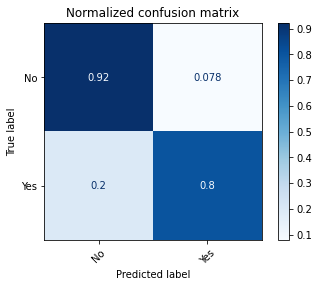

In [59]:
#Plot non-normalized confusion matrix
#Get a random forest classifiert with 100 trees
np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Inference
```
0: Not a Kinase Inhibitor
1: A Kinase Inhibitor
```

In [60]:
print(rf.predict(test_X[11:16]))
print(test_y[11:16])


[0 1 0 0 1]
[0, 1, 0, 0, 1]


# Part 3: Different Approaches for Predicting Whether a Drug is a Kinase Inhibitor


## Random Forest Using Computer Molecular Descriptors



In [64]:
from sklearn.model_selection import train_test_split
seed = 123

train_X, test_X, train_y, test_y = train_test_split(df_m, ys_fit, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    stratify = ys_fit)
train_y = list(train_y)
test_y = list(test_y)

#remove any infinity/NaN inputs in train_X
train_X= np.float32(train_X)
train_X= np.nan_to_num(train_X, nan=-9999, posinf=33333333, neginf=33333333)
rf.fit(train_X, train_y);

In [65]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

test_X= np.float32(test_X)
test_X=np.nan_to_num(test_X, nan=-9999, posinf=33333333, neginf=33333333)
pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))

balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))


Test set accuracy: 0.90
Balanced set Accuracy Score: 0.90


Normalized confusion matrix
[[0.98  0.02 ]
 [0.176 0.824]]


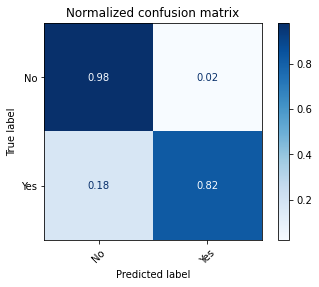

In [66]:
#Plot non-normalized confusion matrix
#Get a random forest classifiert with 100 trees
np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Supervised Learning using KFold Model for Splitting Data

We will utilize KFold model to split the data into 3 sets: training, testing and validation for molecular fingerprint dataset.



0.9508196721311475
Test set accuracy: 0.83
Balanced set Accuracy Score: 0.83
Normalized confusion matrix
[[0.882 0.118]
 [0.216 0.784]]


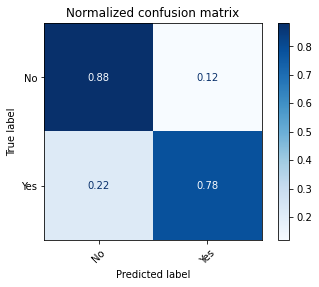

In [73]:
#np_fps
from sklearn.model_selection import KFold
import numpy as np
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
seed = 123

train_X, test_X, train_y, test_y = train_test_split(np_fps, ys_fit, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    stratify = ys_fit)
train_y = list(train_y)
test_y = list(test_y)

trainX = []
trainy = []
score = 0
kf5 = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf5.split(train_y):
  seed = 1123
  rf = RandomForestClassifier(n_estimators=50, random_state=seed)
  rf.fit(train_X[train_index], np.take(train_y,train_index));
  pred_y = rf.predict(train_X[test_index])
  acc = metrics.accuracy_score(np.take(train_y,test_index), pred_y)
  if acc> score:
    trainX = train_X[train_index]
    trainy = np.take(train_y,train_index)
    score = acc

print(score)
seed = 1123
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(trainX, trainy);

pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))
balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))

np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()


We will utilize KFold model to split the data into 3 sets: training, testing and validation for computer molecular descriptors dataset.

0.9180327868852459
Test set accuracy: 0.88
Balanced set Accuracy Score: 0.88
Normalized confusion matrix
[[0.922 0.078]
 [0.157 0.843]]


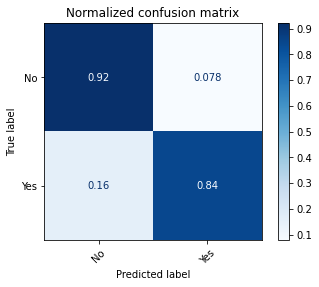

In [74]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
seed = 123

train_X, test_X, train_y, test_y = train_test_split(df_m, ys_fit, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    stratify = ys_fit)
train_y = list(train_y)
test_y = list(test_y)

#remove any infinity/NaN inputs in train_X
train_X= np.float32(train_X)
train_X= np.nan_to_num(train_X, nan=-9999, posinf=33333333, neginf=33333333)
test_X= np.float32(test_X)
test_X= np.nan_to_num(test_X, nan=-9999, posinf=33333333, neginf=33333333)

trainX = []
trainy = []
score = 0
kf5 = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf5.split(train_y):
  seed = 1123
  rf = RandomForestClassifier(n_estimators=50, random_state=seed)
  rf.fit(train_X[train_index], np.take(train_y,train_index));
  pred_y = rf.predict(train_X[test_index])
  acc = metrics.accuracy_score(np.take(train_y,test_index), pred_y)
  if acc> score:
    trainX = train_X[train_index]
    trainy = np.take(train_y,train_index)
    score = acc

print(score)
seed = 1123
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(trainX, trainy);

pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))
balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))

np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

With 5-Fold data splitting model, we are able to get a better prediction for kinase inhibitor data.